In [39]:
import tensorflow as tf
import os
import math
import numpy as np
import glob

from PIL import Image

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow import keras

# 이거 추가로 설치해줘야 됨
from skimage.io import imread
from skimage.transform import resize

# 요거 사용해도 됨
from tensorflow.keras.utils import load_img, img_to_array

import cv2

from Preprocessing import preprocess_image, crop_and_resize_image

import matplotlib.pyplot as plt

In [2]:
# tr : val : ts = 70 : 5 : 25 , 논문에 나와있음
# 1290, 92, 460  / 너무 적은 것 같다. 
# tr : val : ts = 70 : 10 : 20 으로 설정
# 1290, 184, 368
# 순서대로 짜르면 되겠다. 

In [26]:
# RandomGenerator

class DR_Generator(tf.keras.utils.Sequence):
    '''
    tf.keras.utils.Sequence를 상속받아 Sequence를 커스텀해 사용
    '''
    def __init__(self, 
               dir_path,
               mask_path=None,
               batch_size=4,
               img_size=(512, 512),
               n_channels=3,
               is_train=True,
               is_test=False,
               dataset=None):
        '''
        dir_path (str): image path
        mask_path ([str]): mask path
        batch_size (int): batch_size
        img_size (224, 224, 3): 다루는 이미지 사이즈
        dataset (str) : 가져오려는 dataset 이름 , APTOS or FGADR        
        '''
        self.dir_path = dir_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_test = is_test
        self.img_size = img_size
        self.n_channels=n_channels
        self.dataset = dataset
        

        # load_dataset()을 통해서 directory path에서 라벨과 이미지를 확인
        self.data_paths = self.load_dataset()

    def load_dataset(self):
        '''
        path 불러오는 함수  
        tr : val : ts = 70 : 10 : 20
        1290: 184: 368
        '''
        # 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수
        # is_train, is_valid, is_test로 분리함
        
        # 이미지 path 지정
        file_list = os.listdir(self.dir_path)
        input_images_paths = [os.path.join(self.dir_path, file) for file in file_list]
        input_images_paths.sort()

        # mask path 지정
        # unsupervsion 떄는 필요없음
        if self.mask_path:
          mask_images_paths = (os.path.join(self.mask_path, "semantic"))
          mask_images_paths.sort()

          # image와 label 길이가 같은지 확인
          assert len(input_images_paths) == len(mask_images_paths)
        
          # path 합치기
          data_paths = [ _ for _ in zip(input_images_paths, mask_images_paths)]
        
        else:
          data_paths = [_ for _ in zip(input_images_paths)]
        
        
        if self.dataset == "APTOS":
          return data_paths
        
        if self.dataset == "FGADR":
          # train
          if self.is_train:
            return data_paths[:1290]
          # test
          if self.is_test:
            return data_paths[1474:]
          # valid
          return data_paths[1290:1474]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
        return math.ceil(len(self.data_paths) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만드는 함수
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label
        batch_data_paths = self.data_paths[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        
        # 채널 수 바꿔줘야 됨
        inputs = np.zeros([self.batch_size, *self.img_size, self.n_channels])
        outputs = np.zeros([self.batch_size, *self.img_size, self.n_channels])
        
        for i, data in enumerate(batch_data_paths):
            # supervsion 일때는 4개의 label
            # unsupervision 일때는 label이 image가 됨 
            if self.mask_path:
              input_img_path, output_path = data
            
            else:
              input_img_path,  = data
              output = 0
              
            # image
            _input = preprocess_image(input_img_path, img_size=self.img_size)
            
            # mask
            _output = 0
            # _output = img_to_array(load_img(output_path, color_mode='grayscale'))
            # _output = (_output==7).astype(np.uint8)*1
            
            
            inputs[i] = _input
            outputs[i] = _output
        
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수
        # 학습중인 경우에 순서를 random shuffle하도록 적용
        self.indexes = np.arange(len(self.data_paths))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [27]:
tmp = np.zeros([4, *(512, 512), 3])
tmp.shape

(4, 512, 512, 3)

In [28]:
generator_args = {
  'dir_path':'../data/aptos2019-blindness-detection/train_images/',
  'mask_path':None,
  'is_train':True,
  'is_test':False,
  'img_size':(512, 512),  
  'n_channels':3, 
  'batch_size':4,
  'dataset':'APTOS'
}

dr_gen = DR_Generator(**generator_args)

In [30]:
for input, output in dr_gen:
  print(input)
  break

[[[[12.  8. 16.]
   [12.  8. 16.]
   [12.  8. 16.]
   ...
   [11.  7. 15.]
   [12.  8. 16.]
   [12.  8. 16.]]

  [[12.  8. 16.]
   [12.  8. 16.]
   [12.  8. 16.]
   ...
   [11.  7. 15.]
   [12.  8. 16.]
   [12.  8. 16.]]

  [[12.  8. 16.]
   [ 8.  4. 12.]
   [ 9.  5. 13.]
   ...
   [ 8.  4. 12.]
   [ 8.  4. 12.]
   [ 8.  4. 12.]]

  ...

  [[ 8.  8.  8.]
   [12. 12. 12.]
   [11. 11. 11.]
   ...
   [ 8.  8.  8.]
   [ 8.  8.  8.]
   [ 8.  8.  8.]]

  [[ 8.  4. 12.]
   [15. 12. 17.]
   [ 8.  5. 11.]
   ...
   [ 8.  8.  8.]
   [ 8.  8.  8.]
   [12. 12. 12.]]

  [[ 8.  4. 12.]
   [15. 12. 17.]
   [ 8.  5. 11.]
   ...
   [ 8.  8.  8.]
   [ 8.  8.  8.]
   [12. 12. 12.]]]


 [[[12.  8. 15.]
   [16. 12. 19.]
   [ 8.  4. 11.]
   ...
   [11. 10. 10.]
   [12. 12. 10.]
   [ 8.  8.  6.]]

  [[12.  8. 15.]
   [16. 12. 19.]
   [ 8.  4. 11.]
   ...
   [ 5.  4.  3.]
   [ 4.  4.  2.]
   [ 8.  8.  6.]]

  [[10.  6. 13.]
   [12.  8. 15.]
   [12.  8. 15.]
   ...
   [ 8.  7.  7.]
   [ 8.  8.  6.]
   [ 9.  9.

In [31]:
input.shape

(4, 512, 512, 3)

In [42]:
input[:, :, 0]

array([[[12.,  8., 16.],
        [12.,  8., 16.],
        [12.,  8., 16.],
        ...,
        [ 8.,  8.,  8.],
        [ 8.,  4., 12.],
        [ 8.,  4., 12.]],

       [[12.,  8., 15.],
        [12.,  8., 15.],
        [10.,  6., 13.],
        ...,
        [12., 12., 12.],
        [11., 11., 11.],
        [10., 10., 10.]],

       [[ 9.,  8., 13.],
        [ 9.,  8., 13.],
        [ 9.,  8., 13.],
        ...,
        [ 9., 12.,  9.],
        [ 9.,  8., 13.],
        [ 9.,  8., 13.]],

       [[ 4.,  8.,  8.],
        [ 4.,  8.,  8.],
        [ 4.,  8.,  8.],
        ...,
        [ 4.,  4.,  4.],
        [ 4.,  4.,  4.],
        [ 8.,  8.,  8.]]])

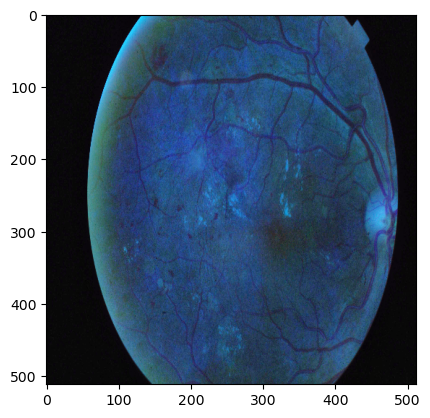

In [45]:
plt.imshow(input[0].astype(np.uint8))